In [1]:
import pandas as pd
import numpy as np

# Data Overview

In [2]:
data = pd.read_csv("../data/penguins.csv")
display(data.head())
print(f"The dataset's size is {data.shape}.")
display(data.info())

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


The dataset's size is (344, 9).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              344 non-null    int64  
 1   species            344 non-null    object 
 2   island             344 non-null    object 
 3   bill_length_mm     342 non-null    float64
 4   bill_depth_mm      342 non-null    float64
 5   flipper_length_mm  342 non-null    float64
 6   body_mass_g        342 non-null    float64
 7   sex                333 non-null    object 
 8   year               344 non-null    int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 24.3+ KB


None

In [3]:
data.drop(['rowid'], axis=1, inplace=True)
data.dropna(inplace=True)
data['year'] = data['year'].astype('object')

In [4]:
desc = pd.DataFrame(index = list(data))
desc['type'] = data.dtypes
desc['count'] = data.count()
desc['nunique'] = data.nunique()
desc['%unique'] = desc['nunique'] / len(data) * 100
desc['null'] = data.isnull().sum()
desc['%null'] = desc['null'] / len(data) * 100
display(desc)

,type,count,nunique,%unique,null,%null
species,object,333,3,0.900901,0,0.0
island,object,333,3,0.900901,0,0.0
bill_length_mm,float64,333,163,48.948949,0,0.0
bill_depth_mm,float64,333,79,23.723724,0,0.0
flipper_length_mm,float64,333,54,16.216216,0,0.0
body_mass_g,float64,333,93,27.927928,0,0.0
sex,object,333,2,0.600601,0,0.0
year,object,333,3,0.900901,0,0.0


## Numerical Features Overview

In [5]:
numerical_features = list(data.select_dtypes(include=['int', 'float']))
display(data.loc[:,numerical_features].describe().T)

,count,mean,std,min,25%,50%,75%,max
bill_length_mm,333.0,43.992793,5.468668,32.1,39.5,44.5,48.6,59.6
bill_depth_mm,333.0,17.164865,1.969235,13.1,15.6,17.3,18.7,21.5
flipper_length_mm,333.0,200.966967,14.015765,172.0,190.0,197.0,213.0,231.0
body_mass_g,333.0,4207.057057,805.215802,2700.0,3550.0,4050.0,4775.0,6300.0


# Data Visualisation

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

## Numerical Features Visualisation

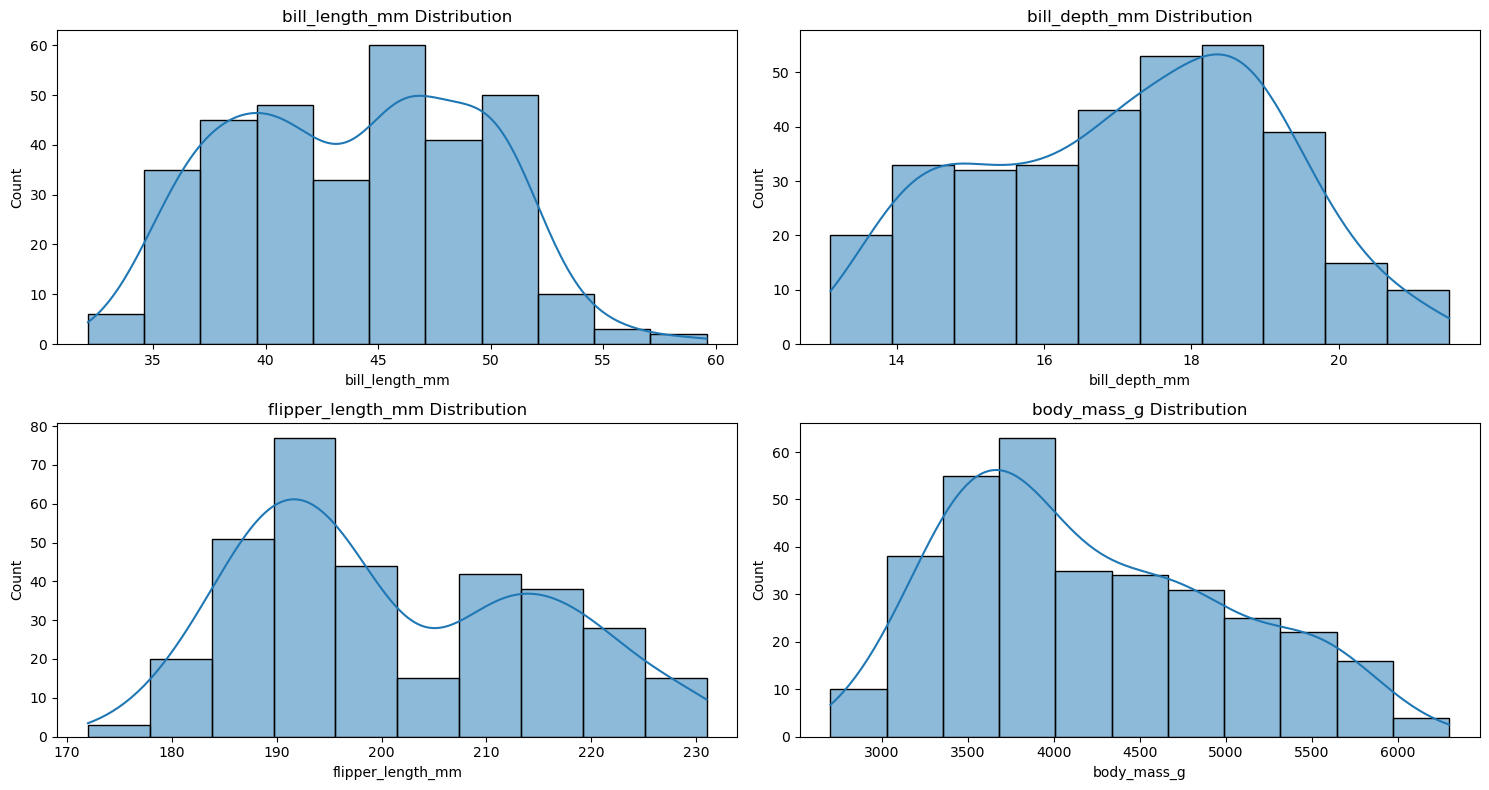

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,8))

for index, (title, ax) in enumerate(zip(numerical_features, axes.flatten())):
    sns.histplot(data=data, x=title, kde=True, ax=ax)
    ax.set_title(title + " Distribution")
    
plt.tight_layout()
plt.show()

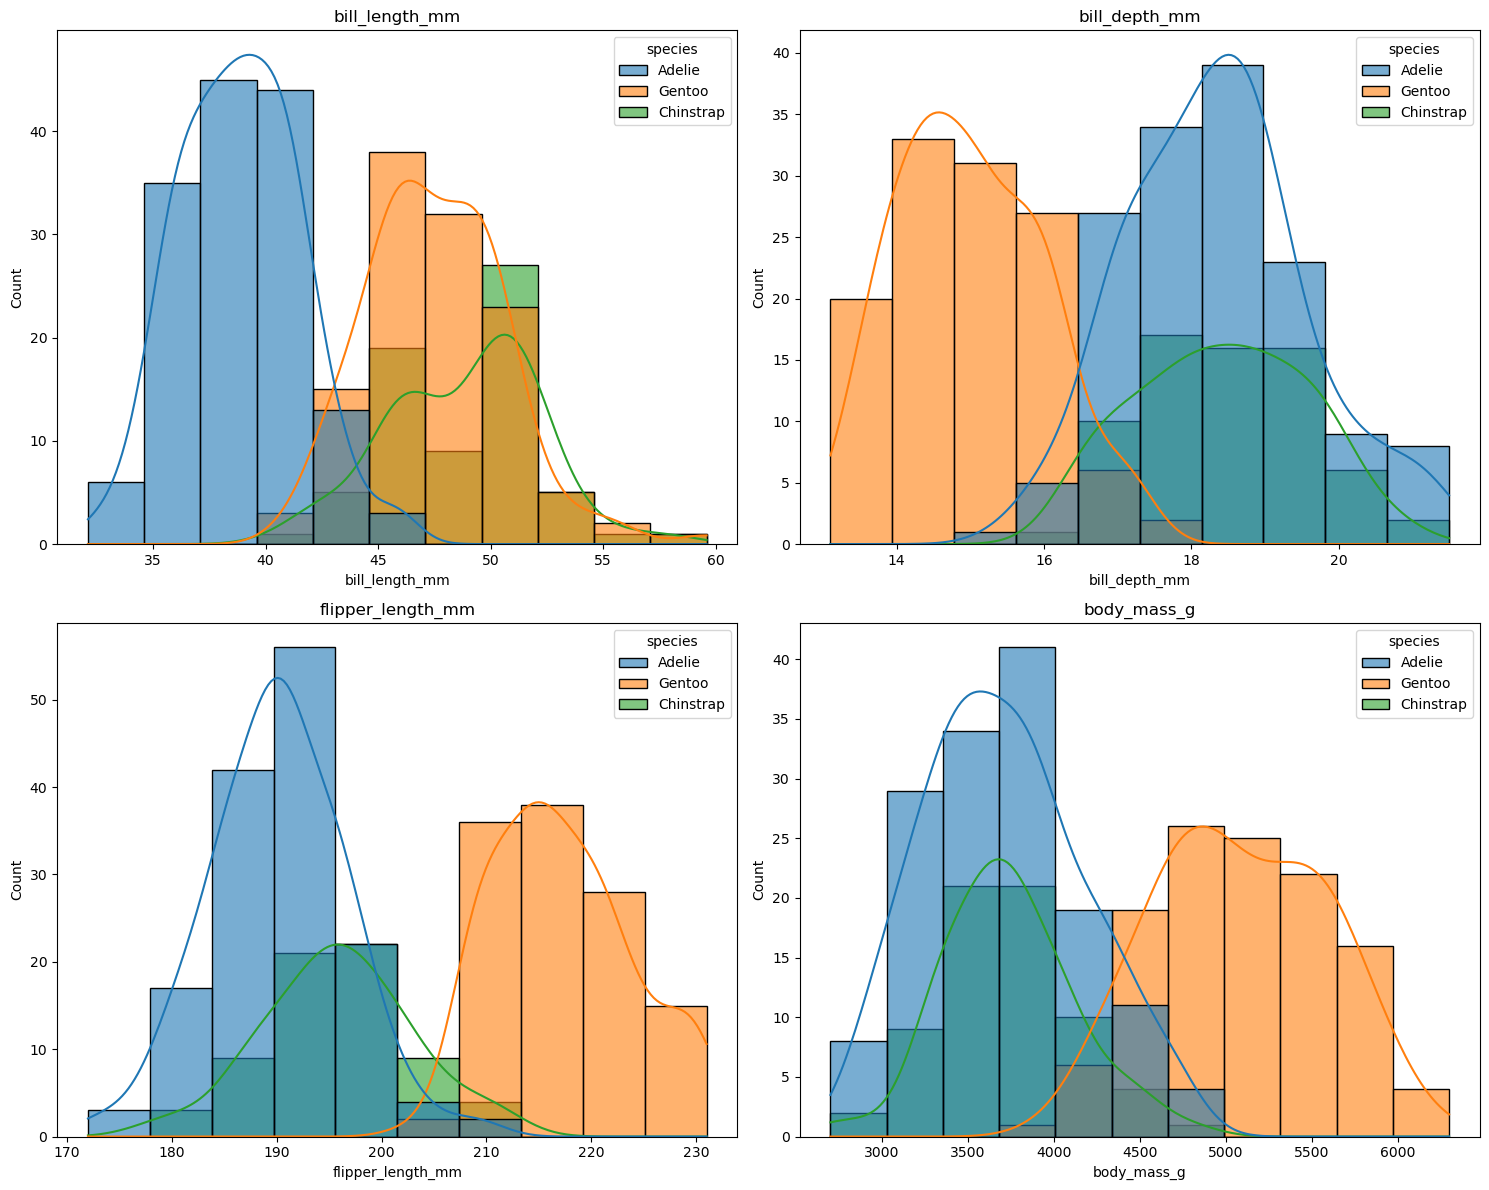

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,12))

for index, (title, ax) in enumerate(zip(numerical_features, axes.flatten())):
    sns.histplot(data=data, x=title, hue='species', kde=True, ax=ax,alpha=0.6)
    ax.set_title(title)
    
plt.tight_layout()
plt.show()

In [9]:
numerical_features

['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

In [10]:
species_type = list(data.species.unique())

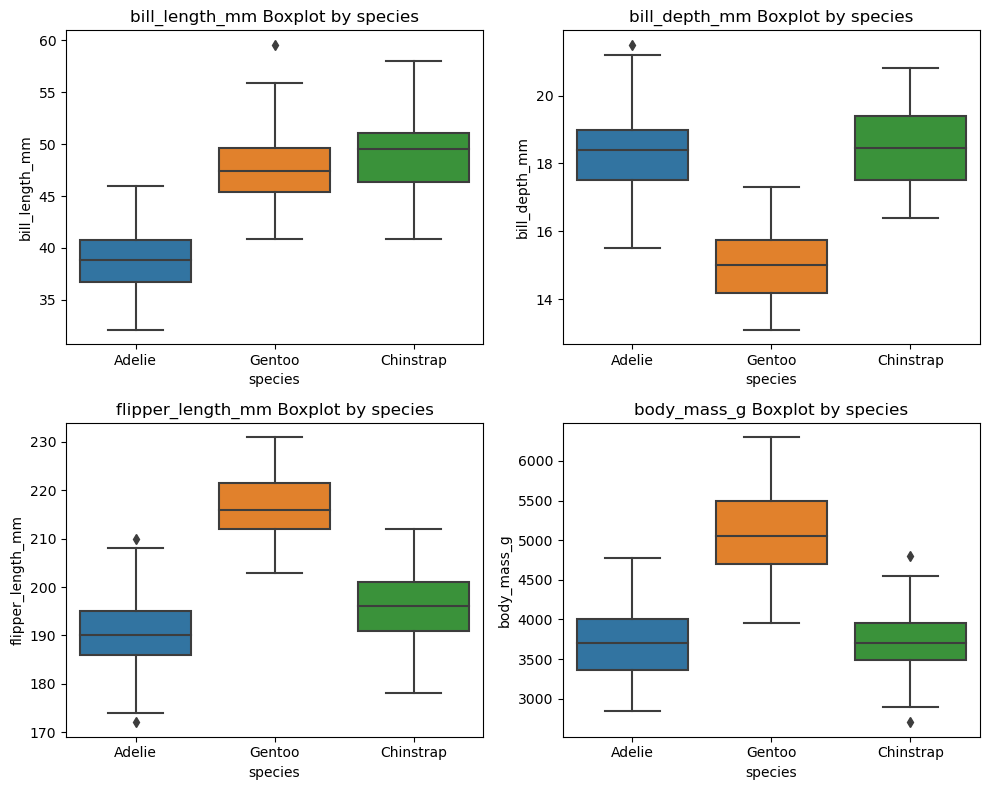

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,8))

for index, (title, ax) in enumerate(zip(numerical_features, axes.flatten())):
    sns.boxplot(x='species', y=title, data=data, ax=ax, order=species_type)
    ax.set_title(f"{title} Boxplot by species")
    
plt.tight_layout()
plt.savefig("../pictures/EDA/numerical_features.png")
plt.show()

## Categorical Features Visualisation

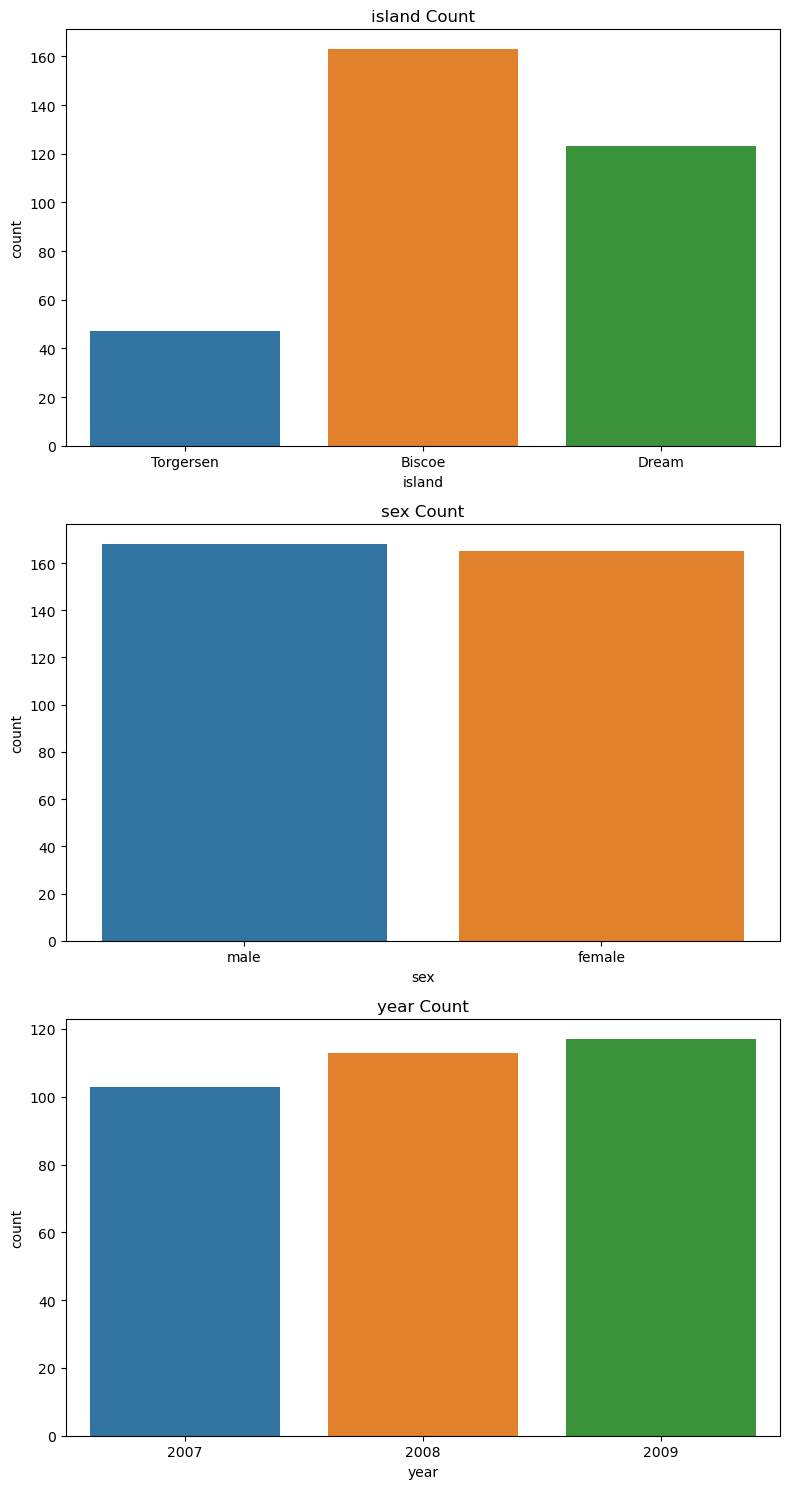

In [12]:
features = list(data)
categorical_features = [feature for feature in features if feature not in numerical_features and feature != 'species']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 15))

for index, (title, ax) in enumerate(zip(categorical_features, axes.flatten())):
    sns.countplot(data=data, x=title, ax=ax)
    ax.set_title(f"{title} Count" )

plt.tight_layout()

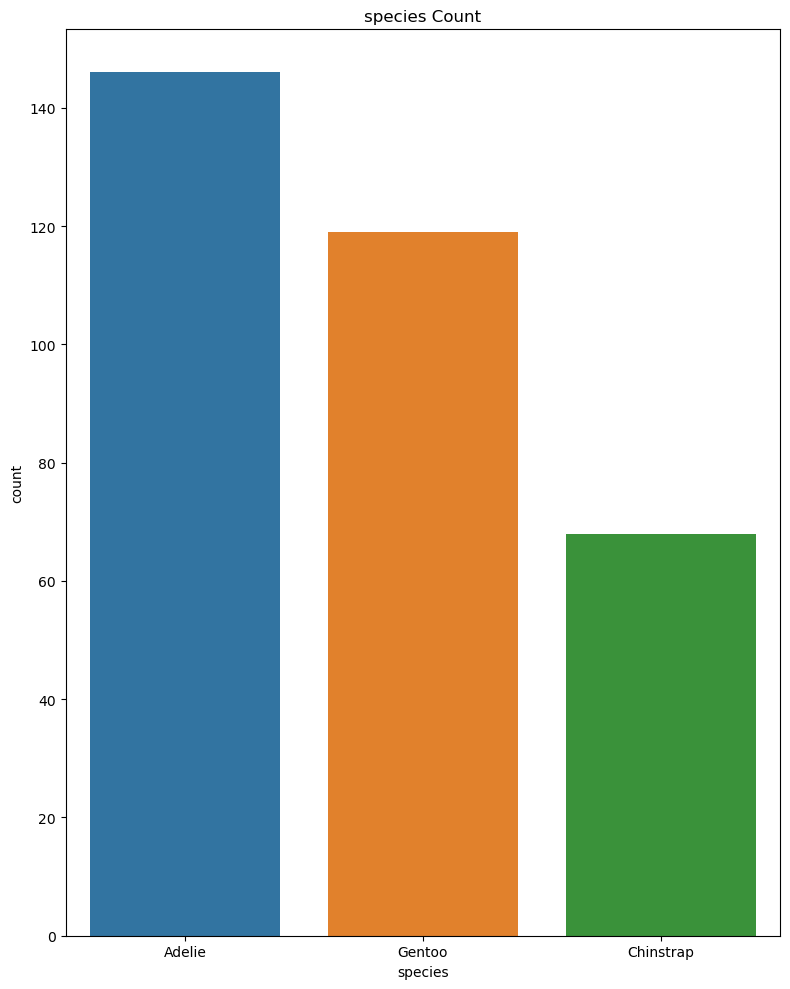

In [13]:
fig, ax = plt.subplots(figsize=(8, 10))

sns.countplot(data=data, x='species', ax=ax)
ax.set_title(f"species Count" )

plt.tight_layout()

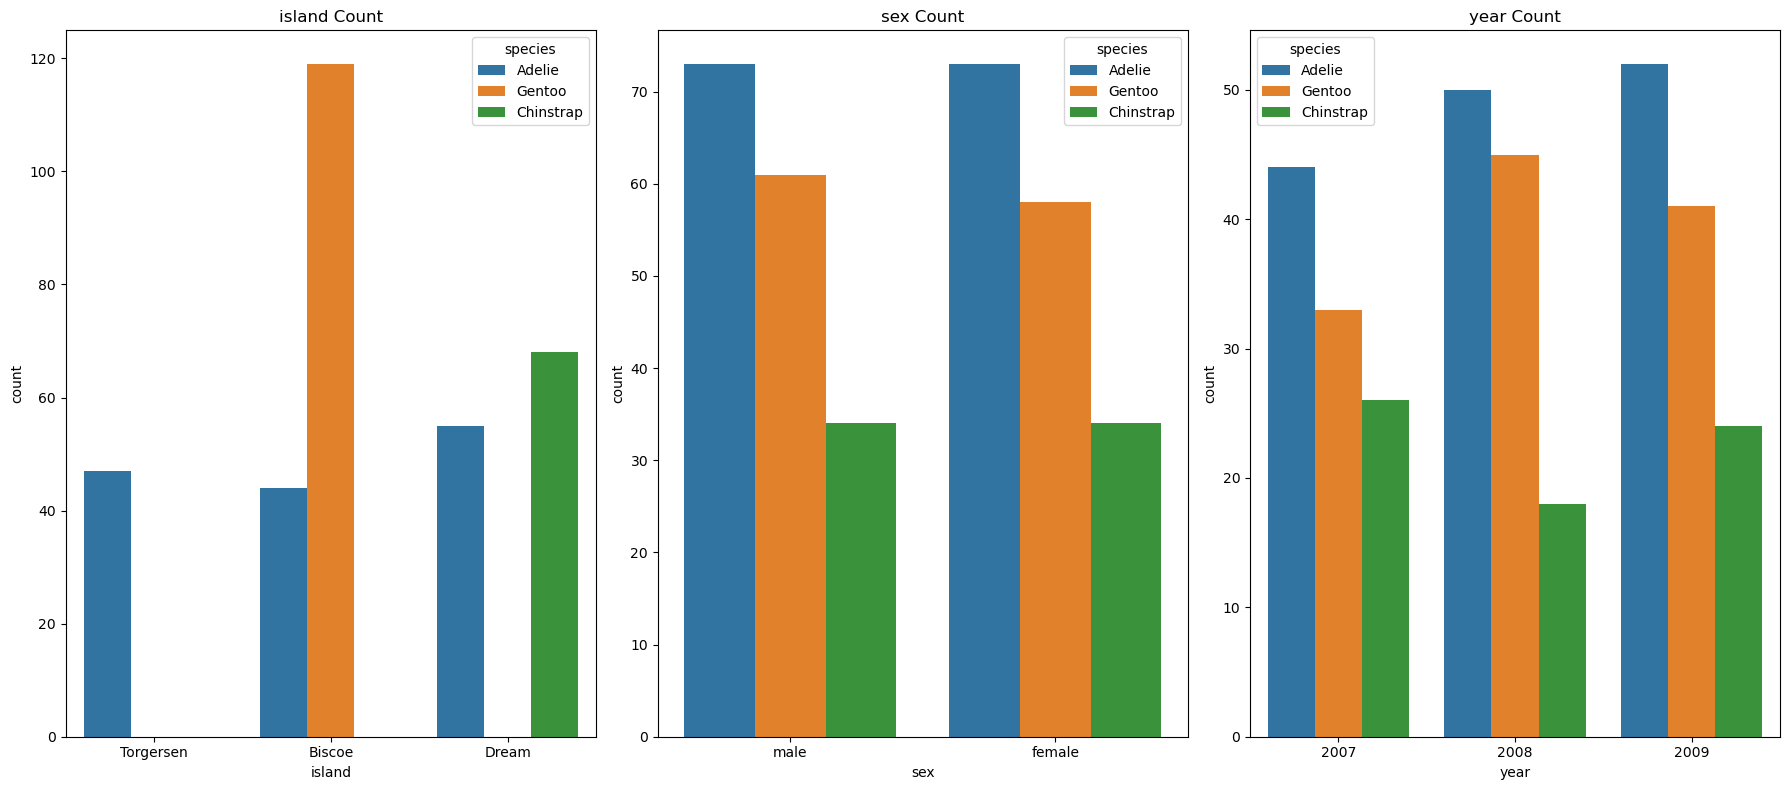

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

for index, (title, ax) in enumerate(zip(categorical_features, axes.flatten())):
    sns.countplot(data=data, x=title, ax=ax, hue='species')
    ax.set_title(f"{title} Count" )

plt.tight_layout()

# Correlation Analysis

In [15]:
from scipy.stats import chi2_contingency

In [16]:
def calculate_cramers_v(df, cat_features, target_feature):
    result = pd.DataFrame(index=cat_features, columns=['Cramers_V', 'p_value'])
    
    for cat_feature in cat_features:
        contingency_table = pd.crosstab(df[cat_feature], df[target_feature])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        
        n = contingency_table.sum().sum()
        k, r = contingency_table.shape
        cramers_v = (chi2 / n) ** 0.5 / min((k-1), (r-1)) ** 0.5
        
        result.loc[cat_feature, 'Cramers_V'] = cramers_v
        result.loc[cat_feature, 'p_value'] = p
    
    return result

In [17]:
def calculate_cramers_v_matrix(df, cat_features):
    result = pd.DataFrame(index=cat_features, columns=cat_features)
    
    for cat_feature_row in cat_features:
        for cat_feature_col in cat_features:
            contingency_table = pd.crosstab(df[cat_feature_row], df[cat_feature_col])
            chi2, _, _, _ = chi2_contingency(contingency_table)

            n = contingency_table.sum().sum()
            k, r = contingency_table.shape
            cramers_v = (chi2 / n) ** 0.5 / min((k-1), (r-1)) ** 0.5

            result.loc[cat_feature_row, cat_feature_col] = cramers_v
    
    return result

## Numerical Feature Correlation Analysis

In [18]:
for feature in numerical_features:
    data[feature+"_binned"] = pd.cut(data[feature], bins=10, labels=False)
num_binned_features = [feature+"_binned" for feature in numerical_features]
target_feature = 'species'
cramers = calculate_cramers_v(data, num_binned_features, target_feature)
display(cramers)

,Cramers_V,p_value
bill_length_mm_binned,0.665094,0.0
bill_depth_mm_binned,0.652707,0.0
flipper_length_mm_binned,0.714799,0.0
body_mass_g_binned,0.627811,0.0


In [19]:
data.columns

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year',
       'bill_length_mm_binned', 'bill_depth_mm_binned',
       'flipper_length_mm_binned', 'body_mass_g_binned'],
      dtype='object')

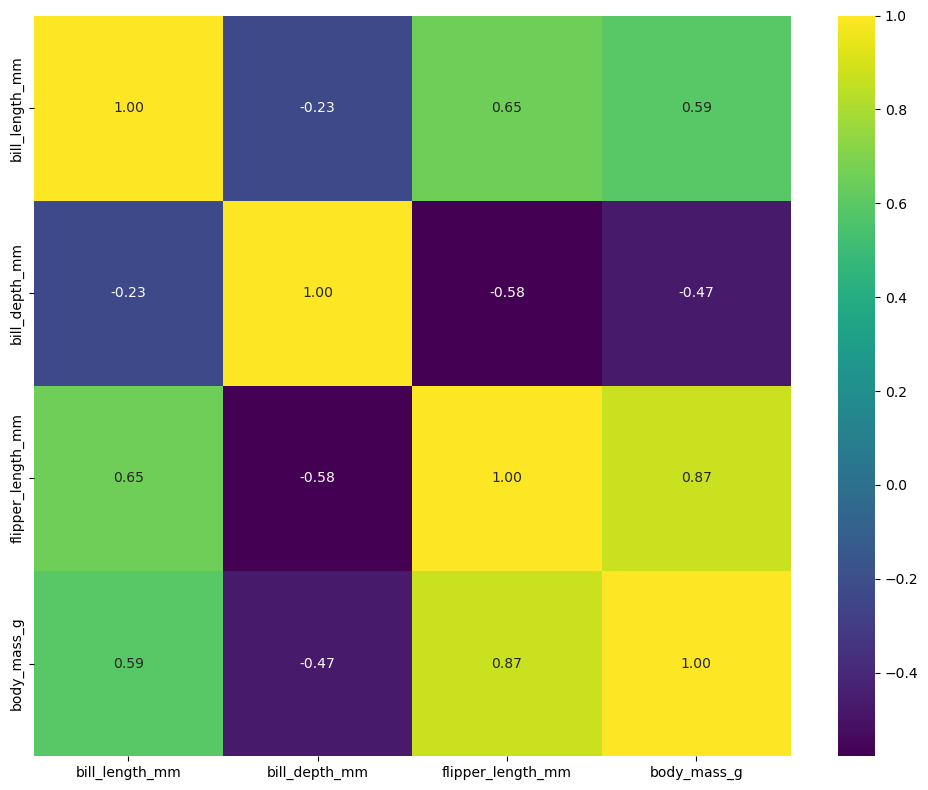

In [20]:
correlation_matrix = data.loc[:,numerical_features].corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap=cm.viridis, fmt='.2f',ax=ax)
plt.tight_layout()
plt.show()

## Categorical Feature Correlation Analysis

In [21]:
cat_features = categorical_features 
target_feature = 'species'
cramers = calculate_cramers_v(data, cat_features, target_feature)
display(cramers)

,Cramers_V,p_value
island,0.653691,0.0
sex,0.012082,0.975989
year,0.070083,0.51352


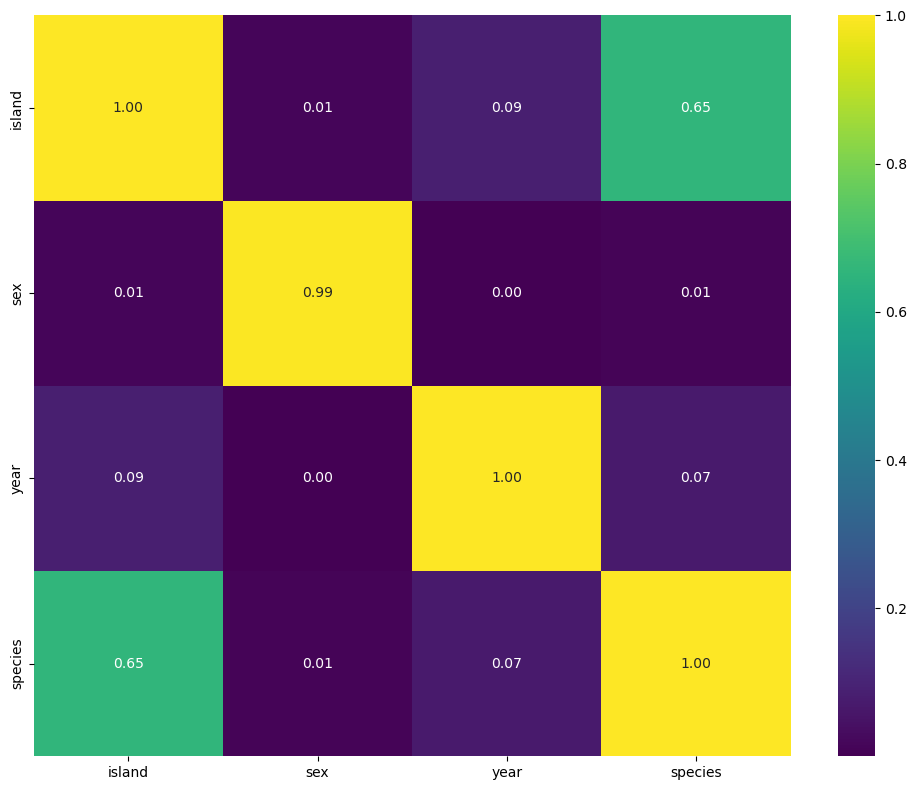

In [22]:
features = cat_features + ['species']
cramers_v_matrix = calculate_cramers_v_matrix(data, features)
cramers_v_matrix = cramers_v_matrix.astype(float)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cramers_v_matrix, annot=True, cmap=cm.viridis, fmt='.2f',ax=ax)
plt.tight_layout()
plt.savefig("../pictures/EDA/Cramér-s-V.png")
plt.show()